# Simulation of NBR06 with measured parameters

In [1]:
from ResSimulator import NBResonator

In [2]:
from TrappingSimulator import QPtrapper

In [3]:
savepath = r"G:\Shared drives\LFL\Simulations\James\NBR06\\"

In [12]:
import os
if not os.path.exists(savepath):
    os.makedirs(savepath)

## definition of parameters used in QP trapper

In [4]:
duration = 0.01 # seconds to record data
sampleRate = 300e6
N = int(duration*sampleRate)
tauTrap = 140e-6
tauRelease = 100e-6
tauCommon = 4e-4
tauRare = 7e-1
tauRecomb = 2e-4
phi = 0.4
Lj = 48.5e-12 # squid inductance at zero phase bias
args = {'N':N,'Lj':Lj,'tauTrap':tauTrap,'tauRelease':tauRelease,'tauCommon':tauCommon,'tauRare':tauRare,
        'tauRecomb':tauRecomb,'sampleRate':sampleRate,'phi':phi,'Delta':2.72370016e-23,'T':0.010}

In [5]:
trapper = QPtrapper(**args)

## Now we have the trapping events, let's generate the resonator response. define some more parameters

In [6]:
L = 1.816e-9
C = 0.7263e-12
Qi = 160000
Qe = 10500
photonRO = 2
delKappa = -0.5

resArgs = {'L':L,'C':C,'photonRO':photonRO,'Qi':Qi,'Qe':Qe,'sampleRate':sampleRate,'delKappa':delKappa}

res = NBResonator(trapper,**resArgs)

In [7]:
res.dParams

{'fd': 4204187812.847265,
 'f0': 4204401161.1799974,
 'Qt': 9853.372434017596,
 'Qi': 160000,
 'Qe': 10500,
 'N': 3000000,
 'q': 0.02601233574684902,
 'photonRO': 2,
 'sampleRate': 300000000.0,
 'kappa': 2681014.219072172,
 'fwhm': 426696.66546499374,
 'diameter': 1.8768328445747802,
 'freq_shift': 436514.1146117863,
 'SNR': 0.004761592961997972,
 'SNRdB': -23.22247732390535,
 'sigma': 14.491851202530862}

## start some analysis with integration for desired SNR

In [31]:
from scipy.constants import pi
from scipy.signal import windows, convolve
avgTime5 = 4*res.dParams['Qt']*5/(res.dParams['photonRO']*2*pi*res.dParams['f0'])
avgTime10 = 4*res.dParams['Qt']*10/(res.dParams['photonRO']*2*pi*res.dParams['f0'])
avgTime25 = 4*res.dParams['Qt']*25/(res.dParams['photonRO']*2*pi*res.dParams['f0'])
avgTime50 = 4*res.dParams['Qt']*50/(res.dParams['photonRO']*2*pi*res.dParams['f0'])
print('integrate for {} us for RF power SNR=5'.format(avgTime5*1e6))
print('integrate for {} us for RF power SNR=50'.format(avgTime50*1e6))

integrate for 3.7299317283967017 us for RF power SNR=5
integrate for 37.299317283967014 us for RF power SNR=50


### perform convolution for SNR of 25

In [36]:
nAvg = int(max(avgTime25*res.dParams['sampleRate'],1))
window = windows.hann(nAvg)
rhann = convolve(res.signal.real,window,mode='same')/sum(window)
ihann = convolve(res.signal.imag,window,mode='same')/sum(window)

### Plot a segment as time series for visual

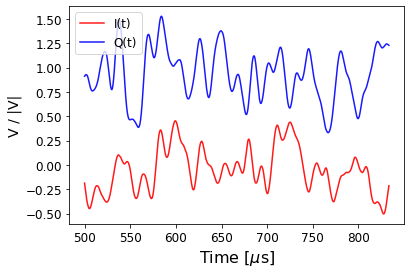

In [37]:
import matplotlib.pyplot as plt
import numpy as np
time = np.arange(res.dParams['N'])/res.dParams['sampleRate']

h = plt.subplot()
h.plot(time[150000:250000]*1e6,rhann[150000:250000],'r',alpha=0.9,label='I(t)')
h.plot(time[150000:250000]*1e6,ihann[150000:250000],'b',alpha=0.9,label='Q(t)')
h.set_xlabel('Time [$\mu$s]',fontsize = 16)
h.set_ylabel('V / |V|',fontsize = 14)
h.tick_params(labelsize=12)
h.legend(fontsize=12)
plt.savefig(savepath+r'NBR06_noisySignal_SNR25.png',format='png')
plt.show()

### plot complex histogram

In [38]:
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

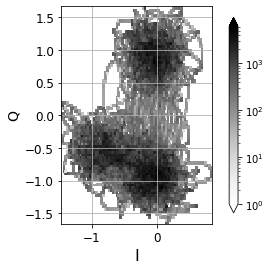

In [39]:
h = plt.subplot()
hs = plt.hist2d(rhann,ihann,bins=(80,80),norm=LogNorm(),cmap=plt.get_cmap('Greys'))
hb = plt.colorbar(hs[-1], shrink=0.9, extend='both')
h.set_aspect('equal')
h.grid()
h.set_xlabel('I',fontsize=16)
h.set_ylabel('Q',fontsize=14)
h.tick_params(labelsize=12)
plt.savefig(savepath+r'NBR06_hist.png',format='png')
plt.show()

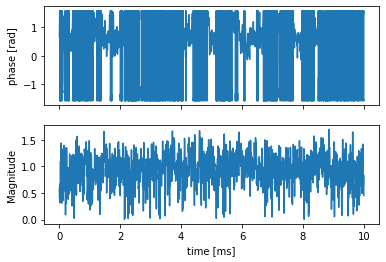

In [40]:
h,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(time*1e3,np.arctan((ihann/rhann)))
ax[0].set_ylabel('phase [rad]')
ax[1].plot(time*1e3,np.sqrt(rhann**2 + ihann**2))
ax[1].set_ylabel('Magnitude')
ax[1].set_xlabel('time [ms]')
plt.savefig(savepath+r'NBR06_mag_phase.png',format='png')
plt.show()

# Is this level of SNR sufficient for machine learning alg to detect occupation?

In [41]:
avgTime25

1.8649658641983507e-05

### We're already averaging for 18.6 microseconds and assuming quantum limited noise

In [42]:
print('avg # trapped = {:.4}'.format(np.mean(trapper.nTrapped)))
print('max # = {}'.format(np.max(trapper.nTrapped)))

avg # trapped = 0.9513
max # = 4


# use scikit package for expectation-maximization algorithm to fit gaussian mixture

In [19]:
from sklearn.mixture import GaussianMixture

### initial guess at mode locations, based on looking at complex hist

In [43]:
theta_guess = [np.pi/2,-np.pi/2,-5*np.pi/6]
means_guess = np.array([np.cos(theta_guess),np.sin(theta_guess)]).T

## run the ML algorithm

In [44]:
estimator = GaussianMixture(n_components = len(means_guess),means_init=means_guess)
estimator.fit(np.array([rhann,ihann]).T)

GaussianMixture(means_init=array([[ 6.12323400e-17,  1.00000000e+00],
       [ 6.12323400e-17, -1.00000000e+00],
       [-8.66025404e-01, -5.00000000e-01]]),
                n_components=3)

### Did it work?

In [45]:
estimator.converged_

True

In [46]:
estimator.means_

array([[-0.03746658,  0.88290071],
       [-0.05761703, -0.90418915],
       [-0.78659126, -0.53239758]])

## Make the pretty plot

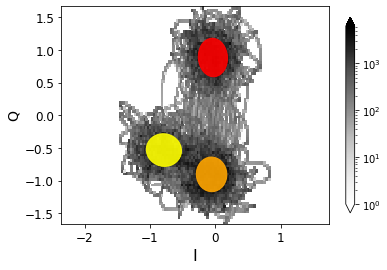

In [47]:
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

colors = ['red','orange','yellow']
def make_ellipses(gmm,ax):
    for n, color in enumerate(colors):
        # get the covariance matrix for the mode associated with n trapped QPs
        covariances = gmm.covariances_[n][:2,:2]
        # v are the eigenvalues of covariance matrix, aka the variances along major and minor axis of ellipse. w are the eigenvectors. Order is smallest to v to largest v
        v, w = np.linalg.eigh(covariances)
        # normalize the eigenvector associated with the smallest variance, i.e., the variance along the minor axis.
        u = w[0] / np.linalg.norm(w[0])
        # get the angle from +x axis to minor axis of ellipse
        angle = 180*np.arctan2(u[1],u[0])/np.pi
        # v is now the diameter of the ellipse in minor, major order. It is equal to 2 std deviations.
        v = 2. *np.sqrt(v)
        # make the ellipse for mode n. Centered at mean with major and minor radius of 1 std deviation. and rotated to align to the data.
        ell = Ellipse(gmm.means_[n,:2],v[0],v[1],180+angle,color=color)
        # now we just add the ellipses to the plot. Note that these ellipses shade the area in which all data points are within 1 std deviation of the mean.
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.9)
        ax.add_artist(ell)
        ax.set_aspect('equal','datalim')

h = plt.subplot()
make_ellipses(estimator,h)
hs = plt.hist2d(rhann,ihann,bins=(80,80),norm=LogNorm(),cmap=plt.get_cmap('Greys'))
hb = plt.colorbar(hs[-1], shrink=0.9, extend='both')
h.set_xlabel('I',fontsize=16)
h.set_ylabel('Q',fontsize=14)
h.tick_params(labelsize=12)
plt.savefig(savepath+r'NBR06_hist_modes.png',format='png')
plt.show()

# Does the estimator accurately predict the trap state?

In [48]:
nEst = np.empty(res.dParams['N'],dtype=int)
nEst[:] = estimator.predict(np.transpose((rhann,ihann)))

### How do the avg number of trapped QPs compare?

In [49]:
print('simulated avg # = {:.4}'.format(np.mean(trapper.nTrapped)))
print('estimator avg # = {:.4}'.format(np.mean(nEst)))

simulated avg # = 0.9513
estimator avg # = 0.9157


### That's a good agreement. How does it look when we plot two segments together?

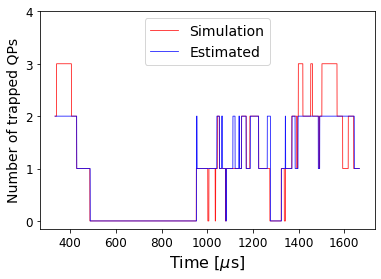

In [50]:
h = plt.subplot()
h.plot(time[100000:500000]*1e6,trapper.nTrapped[100000:500000],'r',alpha=0.9,label='Simulation',lw=0.8)
h.plot(time[100000:500000]*1e6,nEst[100000:500000],'b',alpha=0.9,label='Estimated',lw=0.8)
h.set_xlabel('Time [$\mu$s]',fontsize = 16)
h.set_ylabel('Number of trapped QPs',fontsize = 14)
plt.yticks([0,1,2,3,4])
h.tick_params(labelsize=12)
h.legend(fontsize=14)
plt.savefig(savepath+r'NBR06_estimationComparison.png',format='png')
plt.show()

### Looks like the estimator is switching far too often. perhaps a different averaging method will work better (instead of convolution with Hann window)

## Let's quantitatively look at the error

In [51]:
errTrap = np.diff((nEst,trapper.nTrapped),axis=0)[0]

#### errTrap is the difference, errTrap[i] = nTrapped[i] - nEst[i]. It should be positive when we underestimate and negative when we overestimate. The mean should approach 0 for large dataset unless we are somehow more prone to over or under estimating.

In [52]:
np.mean(errTrap)

0.035548

##### Ok, now let's quantify the error. The root mean square of the difference should tell us what percent of the time we're wrong about the state.

In [53]:
np.sqrt(np.mean(errTrap**2))*100 

34.26738001851518

#### Being wrong 40% of the time isn't exactly something to brag about..

### Actually, the above isn't really how often we're wrong, but overestimates this since errTrap is the difference and can be greater than zero. what we need is an array that is 0 when the estimator is right and 1 when it is wrong. mean of this is the actual percent of time we're wrong.

In [54]:
estFalse = np.array(np.abs(errTrap) > 0,dtype=int)

In [55]:
np.mean(estFalse)

0.087802

# Repeat for exponential window

In [66]:
nAvg = int(max(avgTime25*res.dParams['sampleRate'],1))
window = windows.exponential(nAvg,tau=-(nAvg-1)/np.log(0.00001))
rhann = convolve(res.signal.real,window,mode='same')/sum(window)
ihann = convolve(res.signal.imag,window,mode='same')/sum(window)

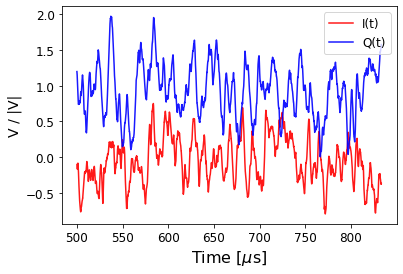

In [67]:
import matplotlib.pyplot as plt
import numpy as np
time = np.arange(res.dParams['N'])/res.dParams['sampleRate']

h = plt.subplot()
h.plot(time[150000:250000]*1e6,rhann[150000:250000],'r',alpha=0.9,label='I(t)')
h.plot(time[150000:250000]*1e6,ihann[150000:250000],'b',alpha=0.9,label='Q(t)')
h.set_xlabel('Time [$\mu$s]',fontsize = 16)
h.set_ylabel('V / |V|',fontsize = 14)
h.tick_params(labelsize=12)
h.legend(fontsize=12)
plt.savefig(savepath+r'NBR06_noisySignal_SNR25_exp.png',format='png')
plt.show()

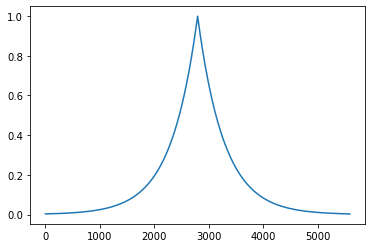

In [68]:
plt.plot(window)

In [59]:
nAvg

5594

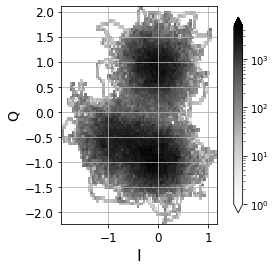

In [69]:
h = plt.subplot()
hs = plt.hist2d(rhann,ihann,bins=(80,80),norm=LogNorm(),cmap=plt.get_cmap('Greys'))
hb = plt.colorbar(hs[-1], shrink=0.9, extend='both')
h.set_aspect('equal')
h.grid()
h.set_xlabel('I',fontsize=16)
h.set_ylabel('Q',fontsize=14)
h.tick_params(labelsize=12)
plt.savefig(savepath+r'NBR06_hist_exp.png',format='png')
plt.show()

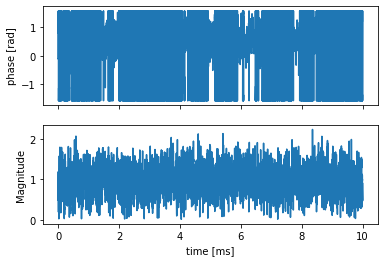

In [70]:
h,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(time*1e3,np.arctan((ihann/rhann)))
ax[0].set_ylabel('phase [rad]')
ax[1].plot(time*1e3,np.sqrt(rhann**2 + ihann**2))
ax[1].set_ylabel('Magnitude')
ax[1].set_xlabel('time [ms]')
plt.savefig(savepath+r'NBR06_mag_phase_exp.png',format='png')
plt.show()

In [71]:
estimator = GaussianMixture(n_components = len(means_guess),means_init=means_guess)
estimator.fit(np.array([rhann,ihann]).T)

GaussianMixture(means_init=array([[ 6.12323400e-17,  1.00000000e+00],
       [ 6.12323400e-17, -1.00000000e+00],
       [-8.66025404e-01, -5.00000000e-01]]),
                n_components=3)

In [72]:
estimator = GaussianMixture(n_components = len(means_guess),means_init=means_guess)
estimator.fit(np.array([rhann,ihann]).T)

### Did it work?

estimator.converged_

estimator.means_

array([[-0.03766465,  0.90128578],
       [-0.03015016, -0.93306193],
       [-0.76029427, -0.55656038]])

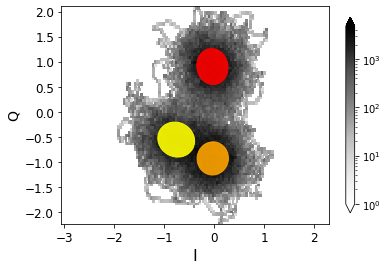

In [73]:
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

colors = ['red','orange','yellow']
def make_ellipses(gmm,ax):
    for n, color in enumerate(colors):
        # get the covariance matrix for the mode associated with n trapped QPs
        covariances = gmm.covariances_[n][:2,:2]
        # v are the eigenvalues of covariance matrix, aka the variances along major and minor axis of ellipse. w are the eigenvectors. Order is smallest to v to largest v
        v, w = np.linalg.eigh(covariances)
        # normalize the eigenvector associated with the smallest variance, i.e., the variance along the minor axis.
        u = w[0] / np.linalg.norm(w[0])
        # get the angle from +x axis to minor axis of ellipse
        angle = 180*np.arctan2(u[1],u[0])/np.pi
        # v is now the diameter of the ellipse in minor, major order. It is equal to 2 std deviations.
        v = 2. *np.sqrt(v)
        # make the ellipse for mode n. Centered at mean with major and minor radius of 1 std deviation. and rotated to align to the data.
        ell = Ellipse(gmm.means_[n,:2],v[0],v[1],180+angle,color=color)
        # now we just add the ellipses to the plot. Note that these ellipses shade the area in which all data points are within 1 std deviation of the mean.
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.9)
        ax.add_artist(ell)
        ax.set_aspect('equal','datalim')

h = plt.subplot()
make_ellipses(estimator,h)
hs = plt.hist2d(rhann,ihann,bins=(80,80),norm=LogNorm(),cmap=plt.get_cmap('Greys'))
hb = plt.colorbar(hs[-1], shrink=0.9, extend='both')
h.set_xlabel('I',fontsize=16)
h.set_ylabel('Q',fontsize=14)
h.tick_params(labelsize=12)
plt.savefig(savepath+r'NBR06_hist_modes_exp.png',format='png')
plt.show()

simulated avg # = 0.9513
estimator avg # = 0.9251


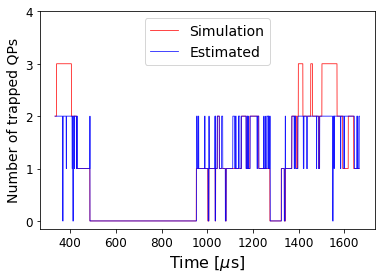

In [74]:
nEst = np.empty(res.dParams['N'],dtype=int)
nEst[:] = estimator.predict(np.transpose((rhann,ihann)))

### How do the avg number of trapped QPs compare?

print('simulated avg # = {:.4}'.format(np.mean(trapper.nTrapped)))
print('estimator avg # = {:.4}'.format(np.mean(nEst)))

### That's a good agreement. How does it look when we plot two segments together?

h = plt.subplot()
h.plot(time[100000:500000]*1e6,trapper.nTrapped[100000:500000],'r',alpha=0.9,label='Simulation',lw=0.8)
h.plot(time[100000:500000]*1e6,nEst[100000:500000],'b',alpha=0.9,label='Estimated',lw=0.8)
h.set_xlabel('Time [$\mu$s]',fontsize = 16)
h.set_ylabel('Number of trapped QPs',fontsize = 14)
plt.yticks([0,1,2,3,4])
h.tick_params(labelsize=12)
h.legend(fontsize=14)
plt.savefig(savepath+r'NBR06_estimationComparison_exp.png',format='png')
plt.show()